#### 作品三：分類器評比 -- Yale 人臉
##### 姓名：嚴潔翎
##### 學號：410878043
##### 目標：利用三份資料，比較不同分類器之表現，並觀察各別對資料做 PCA 後的分類結果，是優於或劣於原始資料。分類器包含三種：邏輯斯迴歸、支援向量機及神經網路。內部參數是決定分類器重要的螺絲，這些參數都能優化模型，使模型在所有訓練數據上的平均損失最小化，而此作品除了比較不同資料帶來的影響外，更透過調整內部參數，達到最佳的分類效果。

<hr>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from numpy.linalg import eig
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
plt.style.use('default')

In [3]:
def show_montage(X, n, m, h, w):
    '''
    X: 影 像 資 料 矩 陣 ， 每 行 代 表 一 張 影 像
    n, m: 每 張 影 像 的 大 小 n x m
    h, w : 建 立 一 個 蒙 太 奇 圖 陣 ， 大小 figsize = (w,h)
    '''
    fig, axes = plt.subplots(h, w, figsize=(w*2, h*2))
    if X.shape[1] < w * h: # 影 像 張 數 不 到 w x h 張 ， 用 0 向量補齊
        X = np.c_[X, np.zeros((X.shape[0], w*h-X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

【資料簡述】此資料來自 The Extended Yale Face database B，共有 2410 張人類正臉照片，共計 38 人，每張大小 192 $\times$ 168，每人約有 59 ~ 64 張人臉影像，每張照片有些微差異。

【分類方法】
1. Logistic Regression
2. SVM
3. Neural Network


【資料處理】
1. 切割資料集：將資料集以 3 : 1 ( 75 % : 25 % ) 分成訓練集、測試集，
2. 標準化：分別對訓練集、測試集標準化，避免因單位不同、數值大小差距過大而造成的分析錯誤。
3. 主成分分析：比較使用「原始資料」與「PCA 後萃取出的資訊」的差異。


# yale faces

In [4]:
D = loadmat('allFaces.mat')
X = D['faces'] # 32256*2410 each column represents an image
y = D['nfaces'].flatten()
m = int(D['m'])  # 168
n = int(D['n'])  # 192
n_persons = int(D['person'])  # 38

X_t = X.T
y_ = np.repeat(np.array(range(1, len(y)+1)), y)  # add label

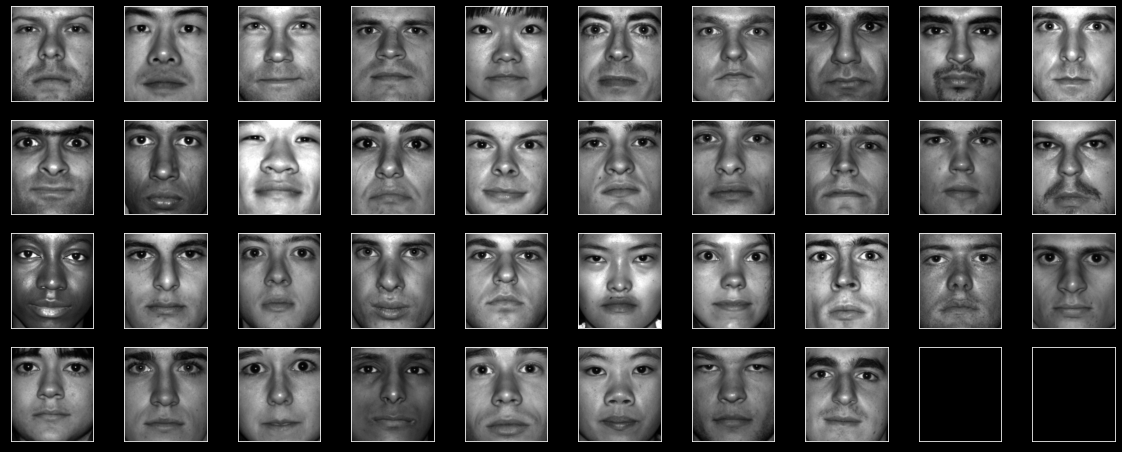

In [4]:
all_diff_persons = np.zeros((m*n, n_persons))
cnt = 0
for i in range(n_persons):
    all_diff_persons[:, i] = X[:,cnt]
    cnt = cnt + y[i]
show_montage(all_diff_persons, n, m, 4, 10)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_t, y_, test_size = 0.3)
# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

## 邏輯斯迴歸

【參數調整】solver
- lbfgs
- liblinear
- newton-cg

【參與資料】
- 原始資料
- 標準化資料
- PCA 資料

In [30]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose = 0)
df = pd.DataFrame()
for sol in ['lbfgs','liblinear','newton-cg']:
    start = time.time()

    clf_LR_original = LogisticRegression(solver = sol, **opts)    
    clf_LR_original.fit(X_train_, y_train)                           
    y_pred = clf_LR_original.predict(X_test_)  

    end = time.time()
    temp = pd.DataFrame(data = {'Method':['Logistic'], 'Acc':[round(clf_LR_original.score(X_test_, y_test), 2)],\
                        'Time':[(end - start)], 'Parameter':[sol]})
    df = pd.concat([df, temp], ignore_index = True)

df

,Method,Acc,Time,Parameter
0,Logistic,0.96,2128.577955,lbfgs
1,Logistic,0.98,3928.762156,liblinear
2,Logistic,0.96,7873.221763,newton-cg


【討論】<br>
雖然 liblinear 演算法有最高的準確率，但所耗時間將近 65 分鐘，而 lbfgs 演算法只需 35 分鐘，足足省下半個小時，而 newton-cg 演算法則因需計算一次偏微及二次偏微，所以需要非常大量計算時間，來到 131 分鐘。故在準確率相距不大的情況下，選擇最省時的 lbfgs 做為學習器的參數。

### 標準化資料

In [9]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=0)
solver = 'lbfgs'
clf_LR_original = LogisticRegression(solver = solver, **opts)    
clf_LR_original.fit(X_train_, y_train)                           
y_pred = clf_LR_original.predict(X_test_)  

print(f"{clf_LR_original.score(X_test_, y_test):.2%}\n")  

97.79%



### PCA 資料

In [ ]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=0)
solver = 'lbfgs'
df = pd.DataFrame()

for i in range(7, 60+1):
    pca = PCA(n_components = i).fit(X_train_)
    cve = round(sum(pca.explained_variance_ratio_), 4)

    Z_train = pca.transform(X_train_)
    Z_test = pca.transform(X_test_)

    clf_LR_pca = LogisticRegression(solver = solver, **opts)    
    clf_LR_pca.fit(Z_train, y_train) 


    temp = pd.DataFrame(data = {'# of components':[i], \
                                'Cummulative variance explained':[cve],\
                                'Accuracy':clf_LR_pca.score(Z_test, y_test)})                          
    df = pd.concat([df, temp], ignore_index = True)

In [60]:
df

,# of components,Cummulative variance explained,Accuracy
0,7,0.8078,0.307054
1,8,0.8183,0.367911
2,9,0.8264,0.492393
3,10,0.8343,0.561549
4,11,0.8413,0.596127
5,12,0.8472,0.639004
6,13,0.8527,0.647303
7,14,0.8578,0.670816
8,15,0.8626,0.710927
9,16,0.8670,0.727524


【討論】

從上表可以看到 7 個主成分能解釋的總變異量達八成，但訓練出來的準確率非常非常低，僅有三成，表示這些變異量不足以分類這些人，雖然後面的主成分所解釋的總變異量差距不大，但每個都是解釋不同人的細節，所以需要納入更多主成分來加強分類的準確率，取到前 34 個主成分才會有九成的準確率，而前 60 個主成分時，有 93.5% 的準確率。

<hr>

## SVM

【參數組合】
- kernel: linear, rbf, poly, sigmoid，共四種
- gamma: scale, auto，共兩種
- decision_function_shape: ovo, ovr，共兩種

【參與資料】
- 標準化
- PCA


In [ ]:
para = {'kernel':('linear','rbf','poly','sigmoid'), 'gamma':('scale','auto'), \
    'decision_function_shape':('ovo','ovr')}
svc = SVC(tol = 1e-6, max_iter = int(1e6))
clf = RandomizedSearchCV(svc, para, cv = 5)   
clf.fit(X_train_, y_train)

In [8]:
print(f"# of folds: {clf.n_splits_}")
print(f"Mean cross-validated score of the best_estimator: {clf.best_score_:.2%}")
print(f"best combination: {clf.best_params_}", end = "\n\n")

# of folds: 5
Mean cross-validated score of the best_estimator: 92.89%
best combination: {'kernel': 'linear', 'gamma': 'auto', 'decision_function_shape': 'ovo'}



【討論】最佳參數組合：
- kernel: linear
- gamma: auto
- decision_function_shape: ovo

根據 RandomizedSearchCV 結果顯示，最佳的核函數為線性，而Gamma 是針對非線性 SVM 所設定的超參數，但此指令同 GridSearchCV 會將所有參數組合在一起，無論實際上是否合理，並將線性的核函數配了一個不存在的 gamma，故在後面的分類器將此參數移除。

In [16]:
%%time
# standardized
opts = dict(decision_function_shape = 'ovo', \
               tol = 1e-6, max_iter = int(1e6))
clf_svm_ori = SVC(kernel = "linear", **opts)     
clf_svm_ori.fit(X_train_, y_train)
predictions = clf_svm_ori.predict(X_test_)
print(f"{clf_svm_ori.score(X_test_, y_test):.2%}\n")   

92.67%

CPU times: total: 1min 3s
Wall time: 7min 2s


In [69]:
pca = PCA(n_components = 40).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)

opts = dict(decision_function_shape = 'ovo', \
               tol = 1e-6, max_iter = int(1e6))
clf_svm_pca = SVC(kernel = "linear", **opts)     
clf_svm_pca.fit(Z_train, y_train)
print(f"{clf_svm_pca.score(Z_test, y_test):.2%}\n")  

90.73%



【討論】

主成分個數取 40 個是因羅吉斯迴歸的結果中，前 40 個主成分的 PCA 資料已有較穩定的準確率，約九成，而帶入 SVM 也是一樣的結果，準確率有 90.73%。

從原本的 32256 個特徵降至 40 個主成分，就有九成的準確率，只是就會捨棄掉重要的臉部細節，對於更精確的分類，40 個主成分就稍嫌不足，需要更多主成分來加強分類的效果。
<hr>

## Neural Network

【參數組合】
- solver: lbfgs, sgd, adam
- activation: identity, relu, logistic
- hidden layer: (20, ), (50, ), (80, ), (100, ), (40, 40), (50, 50)

【參與資料】
- 標準化
- PCA

In [ ]:
para = {'solver':('lbfgs','sgd','adam'), 'activation':('identity','logistic','relu'), \
    'hidden_layer_sizes':((50,), (80,), (100,), (40, 40), (50, 50))}
mlp = MLPClassifier(tol = 1e-4, max_iter = int(1e4))
clf_mlp = GridSearchCV(mlp, para)   
clf_mlp.fit(X_train_, y_train)

In [14]:
# pd.DataFrame(clf_mlp.cv_results_)
print(f'best combination: {clf_mlp.best_params_}')

best combination: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}


In [20]:
# grid
hidden_layers = (100,)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, \
        activation = activation, tol = 1e-6, max_iter = int(1e6))
solver = 'sgd'
clf_MLP_ori = MLPClassifier(solver = solver, **opts)
clf_MLP_ori.fit(X_train_, y_train)
pred_MLP_ori = clf_MLP_ori.predict(X_test_)

clf_MLP_pca = MLPClassifier(solver = solver, **opts)
clf_MLP_pca.fit(Z_train, y_train)
pred_MLP_pca = clf_MLP_pca.predict(Z_test)

【討論】

因所需時間關係，無法 fit 完神經網路的部分，不過有利用 GridSearchCV 找出最佳參數組合為：
- activation: logistic
- solver: sgd
- hidden_layer_sizes: (100, )

分類結果之後會執行一遍，觀察在這大量的資料下，其準確率與其他兩者相比是否較佳。